In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

#import metpy.calc as mpcalc
#from metpy.plots import SkewT
#from metpy.units import units

# Functions, data

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True)

In [3]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [4]:
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [5]:
from scipy.integrate import cumtrapz
def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.26e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def A_npy2(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,a,[np.nan]*(n-1-idxs[-1])])
def A(T,p):
    return xr.apply_ufunc(A_npy2,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Omega_npy(T,p):
    aplus=Aplus_npy(T,p)
    aplushat = np.trapz(aplus,p)/(p[-1]-p[0])
    return cumtrapz(aplus[::-1]-aplushat,p[::-1],initial=0)[::-1]

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Omega(T,p):
    aplus=Aplus(T,p)
    aplushat = pressure_mean(aplus)
    return xr.apply_ufunc(lambda ap,aph,pp : cumtrapz(ap[::-1]-aph,pp[::-1],initial=0)[::-1],
                          aplus,aplushat,p,input_core_dims=[['pressure'],[],['pressure']],output_core_dims=[['pressure']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.26e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq

def Mss(Z,T,p):
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    return pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)


In [6]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [7]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB

In [8]:
%%time
channelwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/",nfiles=60)
channelwrf_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 19.8 s, sys: 9.71 s, total: 29.5 s
Wall time: 26.7 s


In [9]:
hgt = channelwrf.HGT.mean(['south_north','Time'])[::-1]
def plotsection(hgt):
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance (°)")
    ax.set_ylabel("height(m)")
    ax.plot(hgt.west_east,hgt,color='k')
    return ax,ax.twinx()

In [16]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset
from joblib import Parallel, delayed

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

num_cores = 16
wrf.omp_set_num_threads(32)
def compute_cape(simulation_path):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    capecin_list = Parallel(n_jobs=num_cores)(delayed(compute_individual_cape)(file) for file in files)
    return xr.combine_nested(capecin_list,concat_dim='Time')

In [17]:
%time channelcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/")
channelCAPEmean = channelcapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,2400)).mean('Time')

CPU times: user 758 ms, sys: 0 ns, total: 758 ms
Wall time: 29.3 s


In [18]:
channelCINmean = channelcapecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(400,2400)).mean('Time')
channelLFCmean = channelcapecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(400,2400)).mean('Time')

In [25]:


def plot_skewt(sim,title=""):
    slices=[0,40,49,52,60,80,100]
    P = np.array(sim.pressure)[4:-1]* units.hPa
    i=0
    Tups = units.degK*np.array(sim.T_p.isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load())[4:-1]
    qups = np.array(sim.q_p.isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load())[4:-1]
    
    i=3
    Tdws = units.degK*np.array(sim.T_p.isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load())[4:-1]
    qdws = np.array(sim.q_p.isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load())[4:-1]
    
    P=P[::-1]
    Tups=Tups[::-1]
    qups=qups[::-1]
    Tdws=Tdws[::-1]
    qdws=qdws[::-1]
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    Tddws = mpcalc.dewpoint_from_specific_humidity(qdws,Tdws,P)
    
    fig = plt.figure(figsize=(10,7))
    skew = SkewT(fig, rotation=45)
    
    skew.plot(P, Tups, color='orange'      ,label='upstream')
    skew.plot(P, Tdws, color='red'         ,label='downstream 52-60°')
    skew.plot(P, Tdups, color='lawngreen'   ,label='upstream')
    skew.plot(P, Tddws, color='forestgreen' ,label='downstream 52-60°')
    
    
    # Calculate full parcel profile and add to plot as black line
    profups = mpcalc.parcel_profile(P, Tups[0], Tdups[0]).to('degC')
    skew.plot(P, profups, color='grey', linewidth=2)
    skew.shade_cape(P, Tups, profups,color="orange")
    
    # Calculate full parcel profile and add to plot as black line
    profdws = mpcalc.parcel_profile(P, Tdws[0], Tddws[0]).to('degC')
    skew.plot(P, profdws, color='k', linewidth=2)
    skew.shade_cape(P, Tdws, profdws,color="red")
    
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    plt.legend()
    fig.suptitle(title + " || upstream CAPE = %.1f J/kg, downstream = %.1f J/kg"%(mpcalc.cape_cin(P, Tups, Tdups,profups)[0]/units("J/kg"),mpcalc.cape_cin(P, Tdws, Tddws,profdws)[0]/units("J/kg")),fontsize=20)


# Creating new wind profile and input_sounding

## wind profile

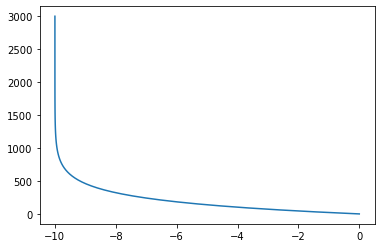

In [8]:
def wind(z):
    return -10*(1-np.exp(-z/200))
z=np.linspace(0,3000,100)
plt.plot(wind(z),z)

## Writing the wind profile

In [170]:
f = open(SCRATCH+'WRF/WRFV4_channel/test/em_beta_plane/input_sounding.backup', "r")
alllines=[]
l=[0]
while len(l)>0 :
    l=f.readline().split()
    alllines.append(l)
alllines = alllines[:-1]    

In [11]:
i=0
f = open(SCRATCH+'WRF/WRFV4_bp_crosseq/test/em_beta_plane/input_sounding', "w")
print('{:>10s}{:10.2f}{:>10s}'.format(alllines[0][0],float(alllines[0][1]),alllines[0][2]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10s}{:10.2f}{:>10s}{:10.2f}{:>10s}'.format(l[0],float(l[1]),l[2],wind(float(l[0])),l[4]),file=f)
f.close()

## Interpolating teperature & moisture profiles

In [171]:
qbt = channelwrf.QVAPOR.isel(Time=slice(-400,-1),west_east=slice(70,100)).mean(['south_north','west_east','Time']).load()
Tbt = 300.+channelwrf.T.isel(Time=slice(-400,-1),west_east=slice(70,100)).mean(['south_north','west_east','Time']).load()
Zbts = 1/9.81*(channelwrf.PH+channelwrf.PHB).isel(Time=slice(-400,-1),west_east=slice(70,100)).mean(['south_north','west_east','Time']).load()

In [172]:
Zbt = np.interp(channelwrf.ZNU.isel(Time=0)[::-1],channelwrf.ZNW.isel(Time=0)[::-1],Zbts[::-1])[::-1]

In [178]:
z = [float(l[0]) for l in alllines[1:]]

In [174]:
q = np.interp(z,Zbt,qbt)
T = np.interp(z,Zbt,Tbt)

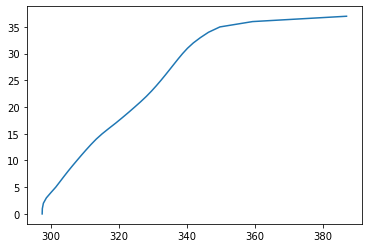

In [114]:
plt.plot(Tbt,Tbt.bottom_top)

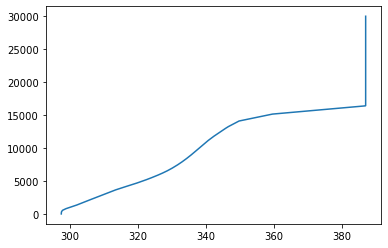

In [116]:
plt.plot(T,z)

In [122]:
i=0
f = open(SCRATCH+'WRF/WRFV4_channel/test/em_beta_plane/input_sounding', "w")
print('{:>10s}{:>10.2f}{:>10.2f}'.format(alllines[0][0],T[0],1000*q[0]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10s}{:>10.2f}{:>10.2f}{:>10.2f}{:>10s}'.format(l[0],T[i],1000*q[i],-10.,l[4]),file=f)
f.close()

## Creating moist adiabatic sounding

In [216]:
z = np.array([float(l[0]) for l in alllines[1:]])

def moist_adiabat(z,SST):
    SST=299.
    p = 1000*np.exp(-9.81*z/(287.*270.)) * units.hPa
    Tp = mpcalc.moist_lapse(p,(SST-1)*units.K)
    thetap = mpcalc.potential_temperature(p,Tp)
    thicknesses = [mpcalc.thickness_hydrostatic(p, Tp,bottom=p[i] ,depth=p[i]-p[i+1])/units.m for i in range(len(p)-1)]
    zp = np.concatenate([[0.],np.cumsum(thicknesses)])
    qp = 0.8*mpcalc.saturation_mixing_ratio(p,Tp)
        
    thetaz = np.interp(z,zp,(thetap/units.K))
    qz = np.interp(z,zp,qp)
    return [float(x) for x in thetaz],[float(x) for x in qz]
%time thetaz,qz = moist_adiabat(z,299)

    

CPU times: user 6.24 s, sys: 7.53 ms, total: 6.25 s
Wall time: 6.24 s


In [217]:
i=0
f = open(SCRATCH+'WRF/WRFV4_channel/test/em_beta_plane/input_sounding', "w")
print('{:>10.2f}{:>10.2f}{:>10.2f}'.format(1000.,thetaz[0],1000*qz[0]),file=f)
for i,zz in enumerate(z):
    print('{:>10.2f}{:>10.2f}{:>10.2f}{:>10.2f}{:>10.2f}'.format(zz,thetaz[i],1000*qz[i],-10.,0.),file=f)
f.close()

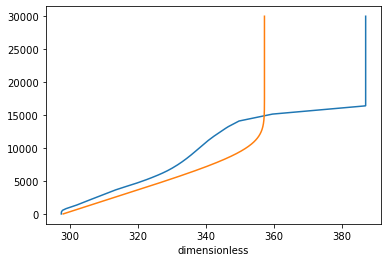

In [213]:
plt.plot(T,z)
plt.plot(thetaz,z)

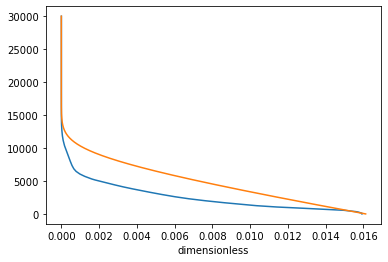

In [214]:
plt.plot(q,z)
plt.plot(qz,z)

In [260]:
# Computing mean tstep
def meantstep(file):
    TESTS="/global/cscratch1/sd/qnicolas/wrfdata/outputs/TESTS/"
    f = open(TESTS+file, "r")
    alllines=[]
    l=[0]
    while len(l)>0 :
        l=f.readline().split()
        alllines.append(l) 
    times=[]
    for l in alllines[26:] :
        try :
            x=float(l[8])
            if x < 0.2 :
                times.append(x)
        except  :
            print(l)
            continue
    return np.mean(times)

In [265]:
meantstep('rsl.out.0000.36457749_knl_3kmChannel_660c1_4x8_38levels_rrtmgf')#'rsl.out.0000.36455529_knl_3kmChannel_660c1_4x8_38levels_rrtmgf')

['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_00_15_00', 'for', 'domain', '1:', '0.05246', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', 'wrfout_d01_1970-01-01_00_30_00', 'for', 'domain', '1:', '0.08848', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_00_30_00', 'for', 'domain', '1:', '0.12071', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_00_45_00', 'for', 'domain', '1:', '0.04182', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', 'wrfout_d01_1970-01-01_01_00_00', 'for', 'domain', '1:', '0.08796', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_01_00_00', 'for', 'domain', '1:', '0.12155', 'elapsed', 'seconds']
['Timing', 'fo

0.1641187610619469

['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_00_15_00', 'for', 'domain', '1:', '0.02622', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', 'wrfout_d01_1970-01-01_00_30_00', 'for', 'domain', '1:', '0.07041', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_00_30_00', 'for', 'domain', '1:', '0.13470', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_00_45_00', 'for', 'domain', '1:', '0.02498', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', 'wrfout_d01_1970-01-01_01_00_00', 'for', 'domain', '1:', '0.06738', 'elapsed', 'seconds']
['Timing', 'for', 'Writing', '/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfpout_d01_1970-01-01_01_00_00', 'for', 'domain', '1:', '0.13937', 'elapsed', 'seconds']
['Timing', 'fo

# Analysis of the fully interactive run

## Lon-lev cross sections

In [20]:
hgt.isel(west_east=49).load()

<xarray.DataArray 'HGT' ()>
array(1000., dtype=float32)

In [17]:
w = channelwrf.W.isel(Time=slice(200,720)).mean(["Time","south_north"])
w_plot=w.assign_coords({'distance_from_mtn':(49-w.west_east)*100,'eta_level':channelwrf.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

Text(0.5, 1.0, 'Moist, coarse simulation - W (nonlinear scale)')

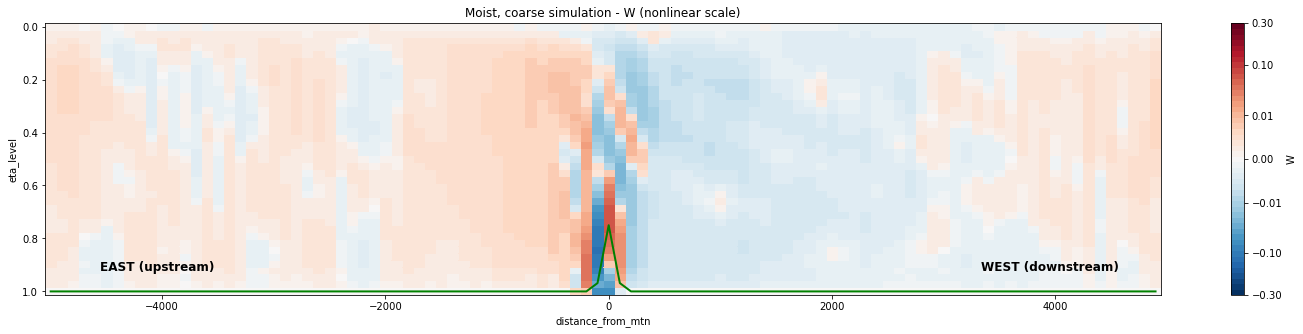

In [18]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, coarse simulation - W (nonlinear scale)")


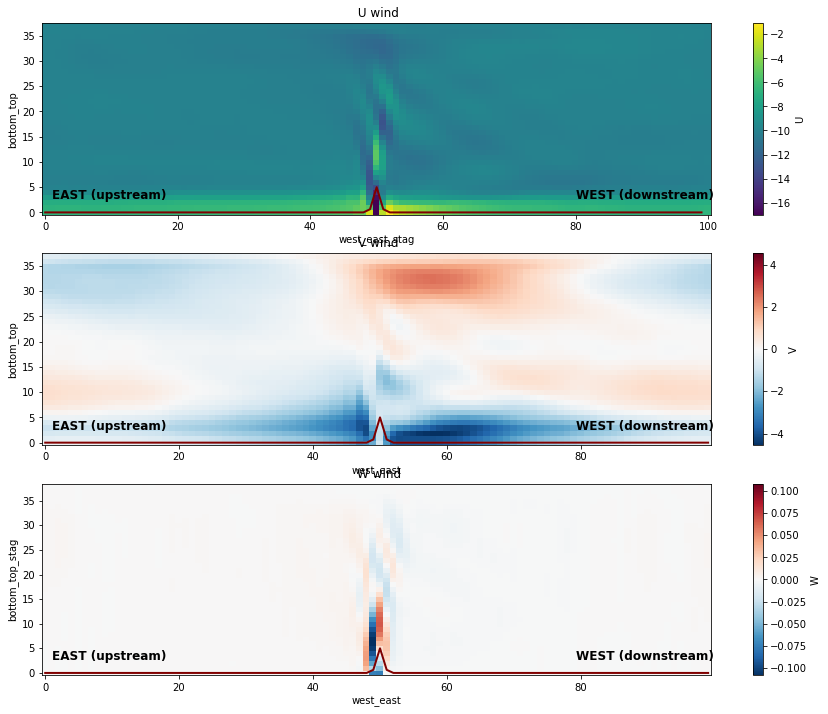

In [347]:
_,ax=plt.subplots(3,1,figsize=(15,12))
ax=ax.reshape(-1)
i=0

channelwrf.U.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1].plot(ax=ax[0], x='west_east_stag')
channelwrf.V.isel(Time=slice(-400,-1)).mean(["Time","south_north_stag"])[:,::-1].plot(ax=ax[1], x='west_east')#,vmin=-6,vmax=6,cmap=plt.cm.RdBu_r)
channelwrf.W.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1].plot(ax=ax[2], x='west_east')#,vmin=-6,vmax=6,cmap=plt.cm.RdBu_r)

ax[0].plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
ax[1].plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
ax[2].plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)

ax[0].set_title(" U wind")
ax[1].set_title(" V wind")
ax[2].set_title(" W wind")

for a in ax:
    add_text(a)



    

Text(0.5, 1.0, 'Fully interactive simulation - W (nonlinear scale)')

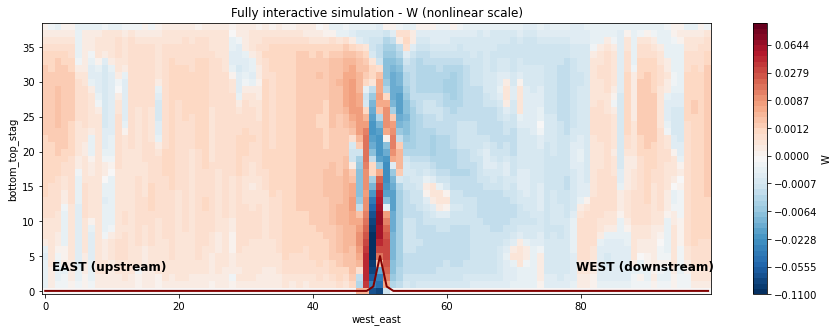

In [42]:
_,ax=plt.subplots(1,1,figsize=(15,5))
w=channelwrf.W.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1]
w.plot(ax=ax, x='west_east', levels=np.linspace(-(0.11)**(1/3),0.11**(1/3),50)**3)
ax.plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive simulation - W (nonlinear scale)")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


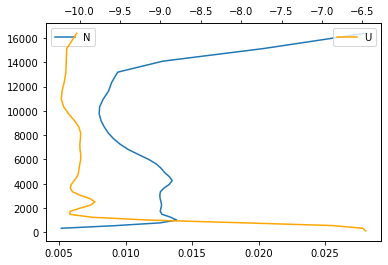

In [344]:
# Brunt vaisala frequency
theta = channelwrf.T.isel(west_east=slice(60,100),Time=slice(400,2400)).mean(["Time","west_east","south_north"]).persist()+300
Z = (channelwrf.PHB+channelwrf.PH).isel(west_east=slice(60,100),Time=slice(400,2400)).mean(["Time","west_east","south_north"]).persist()/9.81
Z=np.interp(channelwrf.ZNU.isel(Time=0)[::-1],channelwrf.ZNW.isel(Time=0)[::-1],np.array(Z)[::-1])[::-1]
dthetadz = np.gradient(theta,Z, edge_order=2)
N = np.sqrt(9.81/theta*dthetadz)

U = channelwrf.U.isel(west_east_stag=slice(60,100),Time=slice(400,2400)).mean(["Time","west_east_stag","south_north"]).persist()


_,ax=plt.subplots(1,1)
ax.plot(N,Z,label="N")
ax.legend()
ax2 = ax.twiny()
ax2.plot(U,Z,label="U",color="orange")
ax2.legend()

So $N \simeq 0.01 s^{-1}$, $u_0 \simeq 10 m/s$,and the mountain width here is 250 km. Hence $N/u_0 = 10^{-3} m^{-1} \gg 1/a \simeq f/u_0$ (Corresponds to figure 3 of Queney 1958)

## Longitudinal cross sections

In [24]:
channelprecip = 4*(channelwrf.RAINC+channelwrf.RAINNC).isel(Time=slice(400,2400)).diff('Time').persist()


Text(0.5, 1.0, 'Fully interactive simulation')

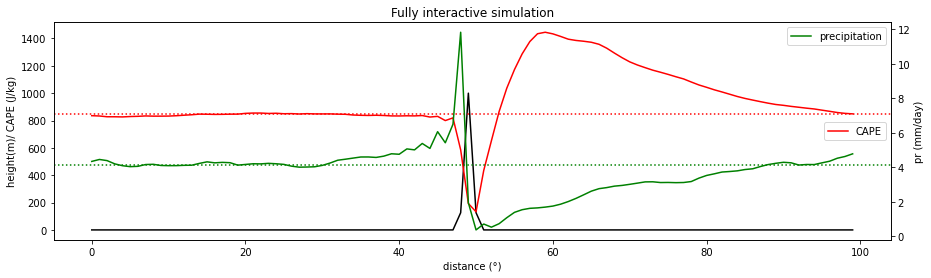

In [48]:
ax,ax2=plotsection(hgt)
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean.west_east,channelCAPEmean.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip.west_east,channelprecip.mean(['south_north','Time'])[::-1],color='green',label='precipitation')
ax2.axhline(channelprecip.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend(loc="center right")
ax2.legend()

ax.set_title("Fully interactive simulation")

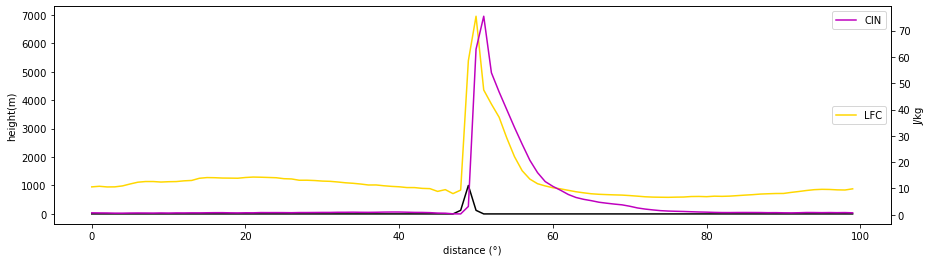

In [298]:
ax,ax2=plotsection(hgt)
ax.plot(channelLFCmean.west_east,channelLFCmean.mean('south_north')[::-1],color='gold',label="LFC")
ax2.set_ylabel("J/kg")
ax2.plot(channelCINmean.west_east,channelCINmean.mean('south_north')[::-1],color='m',label="CIN")
ax.legend(loc="center right")
ax2.legend()

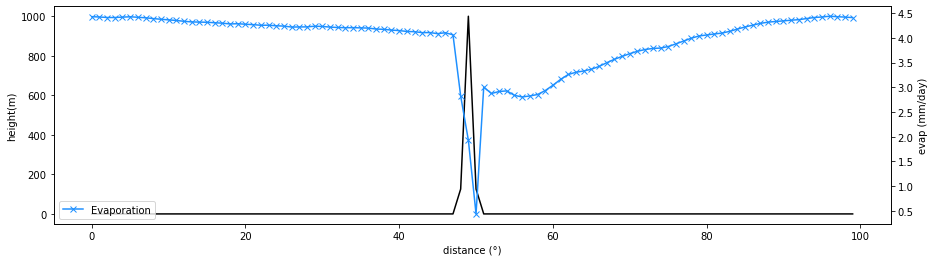

In [272]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("evap (mm/day)")
ax2.plot(channelwrf.west_east,86400*channelwrf.QFX.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='dodgerblue',label="Evaporation")
ax2.legend()



In [238]:
R = rad_cooling(channelwrf.isel(Time=slice(400,2400))).mean(['south_north']).persist()

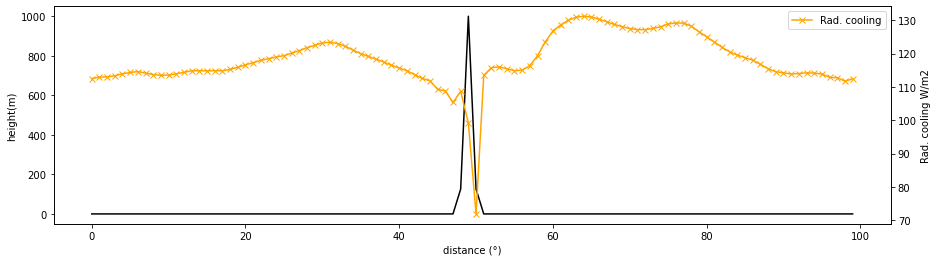

In [274]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("Rad. cooling W/m2")
ax2.plot(R.west_east,R[::-1],'-x',color='orange',label="Rad. cooling")
ax2.legend()

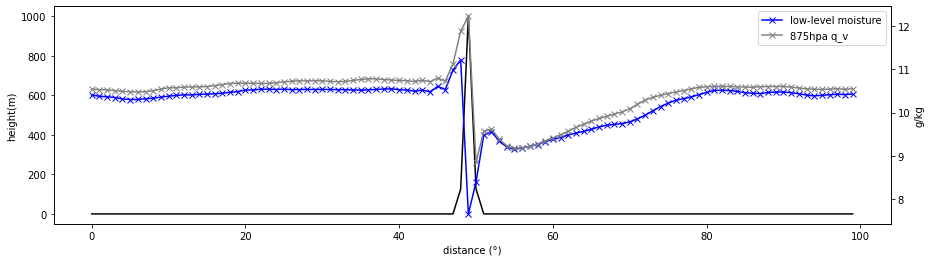

In [282]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("g/kg")
ax2.plot(channelwrf.west_east,1e3*channelwrf.QVAPOR.isel(bottom_top=5,Time=slice(-800,-1)).mean(['south_north','Time'])[::-1],'-x',color='blue',label="low-level moisture")
ax2.plot(channelwrf_p.west_east,1e3*channelwrf_p.q_p.sel(pressure=875.).isel(time=slice(-800,-1)).mean(['south_north','time'])[::-1],'-x',color='grey',label="875hpa q_v")
ax2.legend()


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


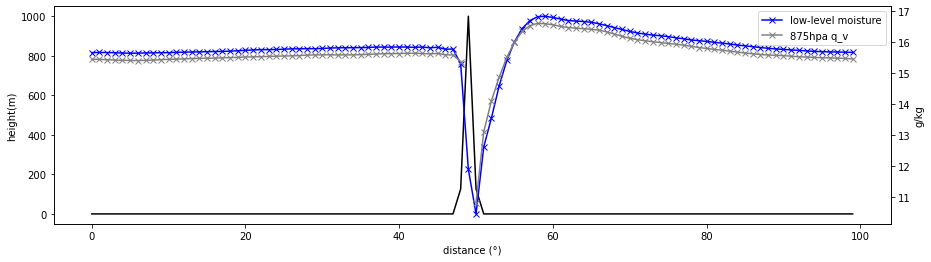

In [307]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("g/kg")
ax2.plot(channelwrf.west_east,1e3*channelwrf.QVAPOR.isel(bottom_top=1,Time=slice(-800,-1)).mean(['south_north','Time'])[::-1],'-x',color='blue',label="low-level moisture")
ax2.plot(channelwrf_p.west_east,1e3*channelwrf_p.q_p.sel(pressure=975.).isel(time=slice(-800,-1)).mean(['south_north','time'])[::-1],'-x',color='grey',label="875hpa q_v")
ax2.legend()


In [213]:
Mh,Ms,Mq = M(channelwrf_p.Z_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             channelwrf_p.q_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             channelwrf_p.T_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             100*channelwrf_p.isel(pressure=slice(6,29),time=slice(400,1200)).pressure.load()
            )

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


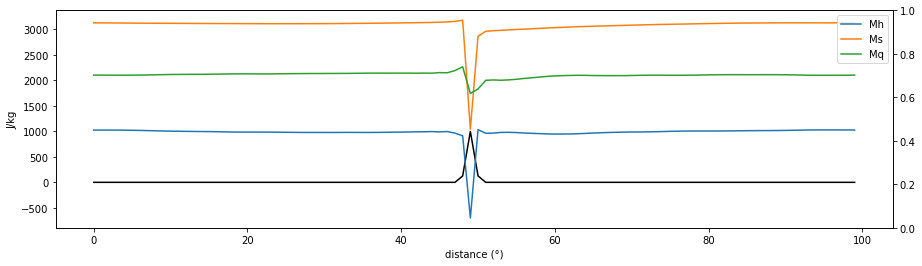

In [303]:
ax,ax2 = plotsection(hgt)
ax.set_ylabel("J/kg")
ax.plot(Mh.west_east,Mh[::-1],label="Mh")
ax.plot(Ms.west_east,Ms[::-1],label="Ms")
ax.plot(Mq.west_east,Mq[::-1],label="Mq")
ax.legend()

#ax2.plot(Mh.west_east,Ms[::-1]/Mh[::-1],label="Ms/Mh",color="m")
#ax2.legend(loc="center right")

## soundings

O° is upstream and 100° is downstream !!


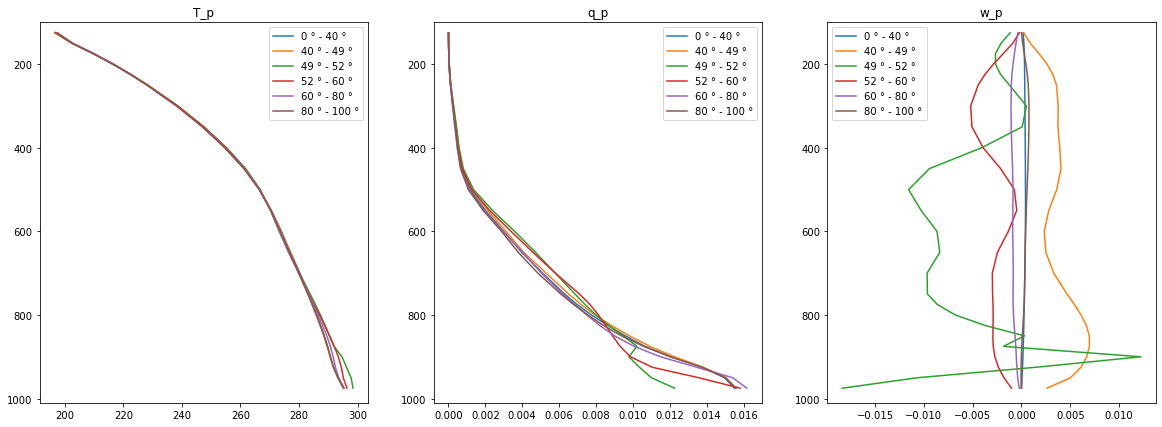

In [14]:
slices=[0,40,49,52,60,80,100]
print("O° is upstream and 100° is downstream !!")
fig, ax = plt.subplots(1,3,figsize=(20,7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    for j,var in enumerate(["T_p","q_p","w_p"]):
        for i in range(len(slices)-1):
            ax[j].plot(channelwrf_p[var].isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load(),channelwrf_p.pressure,label="%i ° - %i °"%(slices[i],slices[i+1]))
        ax[j].set_title(var)
        ax[j].set_ylim(1010,100)
        ax[j].legend()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/plots/skewt.py:131: MatplotlibDeprecationWarning: 
The 'label' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any par

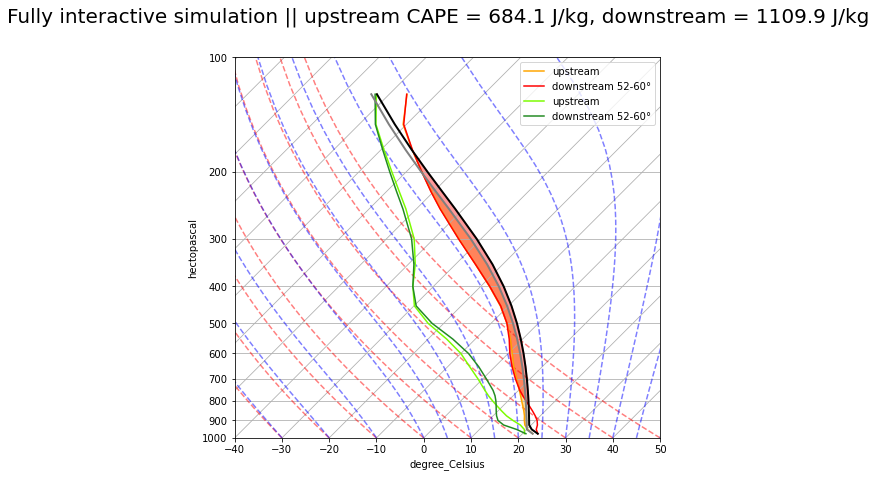

In [38]:
plot_skewt(channelwrf_p,"Fully interactive simulation")


## Spinup tests

In [219]:
channelwrf_youi = extract_wrfout("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/old/",nfiles=30)
channelwrf_newi = extract_wrfout("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/new/",nfiles=30)


In [224]:
def plot_timeseries_diff2(simulation1,simulations,variable,ax,scale=None):
    initvar = simulation1[variable].isel(Time=slice(0,1200)).mean('south_north')
    endvar  = simulation1[variable].isel(Time=slice(1000,1200)).mean(['south_north','Time']).persist()
    ax.plot(initvar.Time,np.sqrt(((initvar-endvar)**2).mean(initvar.dims[1:])),label='control')
    for i,sim in enumerate(simulations):
        initvar2 = sim[variable].mean('south_north')
        ax.plot(initvar2.Time,np.sqrt(((initvar2-endvar)**2).mean(initvar.dims[1:])),label='compared %i'%i)
    ax.set_title(simulation1[variable].description + " sqrt(mean sq diff), rel. to last 50 days")
    ax.legend()
    
def plot_timeseries_diff_rain2(simulation1,simulations,ax,scale=None):
    initvar = 4*(simulation1.RAINC+simulation1.RAINNC).isel(Time=slice(0,1200)).diff('Time').mean('south_north').load()
    initvar_rolling = initvar.rolling(Time=40,center=True).mean()
    endvar  = 4*(simulation1.RAINC+simulation1.RAINNC).isel(Time=slice(1000,1200)).diff('Time').mean(['south_north','Time']).persist() #
    
    ax.plot(initvar.Time,np.sqrt(((initvar_rolling-endvar)**2).mean(initvar.dims[1:])),label='10 day rolling mean precip, control')
    for i,sim in enumerate(simulations):
        initvar2 = 4*(sim.RAINC+sim.RAINNC).diff('Time').mean('south_north').load()
        initvar2_rolling = initvar2.rolling(Time=40,center=True).mean()
        ax.plot(initvar2.Time,np.sqrt(((initvar2_rolling-endvar)**2).mean(initvar2.dims[1:])),label='10 day rolling mean precip, compared %i'%i)
    ax.set_title("precip, sqrt(mean sq diff), rel. to last 50 days")
    ax.legend()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'anomalies relative to the last 50 days; control')

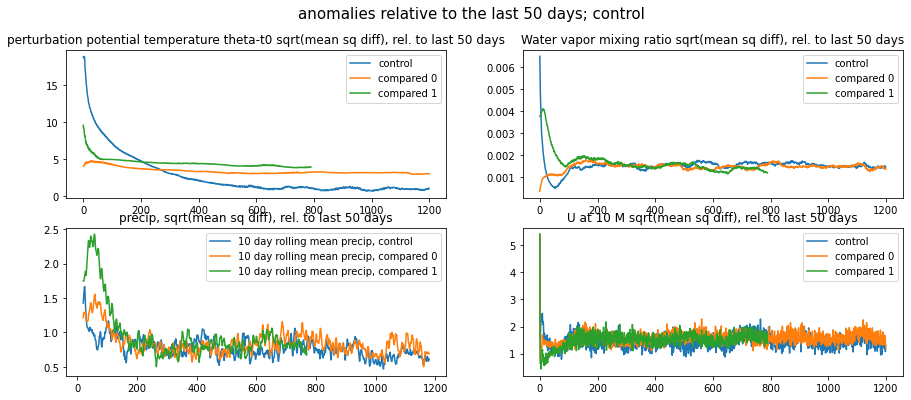

In [225]:
fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff2(     channelwrf,[channelwrf_youi,channelwrf_newi],"T"     ,ax[0])
plot_timeseries_diff2(     channelwrf,[channelwrf_youi,channelwrf_newi],"QVAPOR",ax[1])
plot_timeseries_diff2(     channelwrf,[channelwrf_youi,channelwrf_newi],"U10"   ,ax[3])
plot_timeseries_diff_rain2(channelwrf,[channelwrf_youi,channelwrf_newi]         ,ax[2])
fig.suptitle("anomalies relative to the last 50 days; control",fontsize=15)

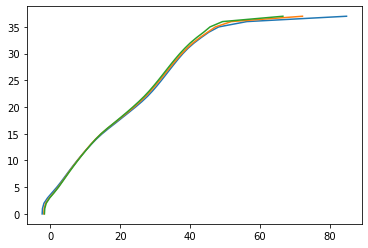

In [226]:
plt.plot(channelwrf.T.isel(Time=slice(400,750)).mean(['south_north','west_east','Time']),channelwrf.bottom_top)
plt.plot(channelwrf_youi.T.isel(Time=slice(400,750)).mean(['south_north','west_east','Time']),channelwrf_youi.bottom_top)
plt.plot(channelwrf_newi.T.isel(Time=slice(400,750)).mean(['south_north','west_east','Time']),channelwrf_newi.bottom_top)


In [227]:
%time channelcapecin_newi = compute_cape("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/new/")
channelCAPEmean_newi  = channelcapecin_newi .isel(mcape_mcin_lcl_lfc=0,Time=slice(400,750)).mean('Time')
%time channelprecip_newi = 4*(channelwrf_newi.RAINC+channelwrf_newi.RAINNC).isel(Time=slice(400,750)).diff('Time').persist()

CPU times: user 152 ms, sys: 1.02 s, total: 1.17 s
Wall time: 11.8 s
CPU times: user 206 ms, sys: 59.7 ms, total: 266 ms
Wall time: 227 ms


In [228]:
%time channelcapecin_youi = compute_cape("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/old/")
channelCAPEmean_youi  = channelcapecin_youi .isel(mcape_mcin_lcl_lfc=0,Time=slice(400,750)).mean('Time')
%time channelprecip_youi = 4*(channelwrf_youi.RAINC+channelwrf_youi.RAINNC).isel(Time=slice(400,750)).diff('Time').persist()

CPU times: user 155 ms, sys: 18.2 ms, total: 174 ms
Wall time: 4.67 s
CPU times: user 180 ms, sys: 18.3 ms, total: 198 ms
Wall time: 170 ms


In [229]:
channelprecip = 4*(channelwrf.RAINC+channelwrf.RAINNC).isel(Time=slice(400,750)).diff('Time').persist()
channelCAPEmean = channelcapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,750)).mean('Time')

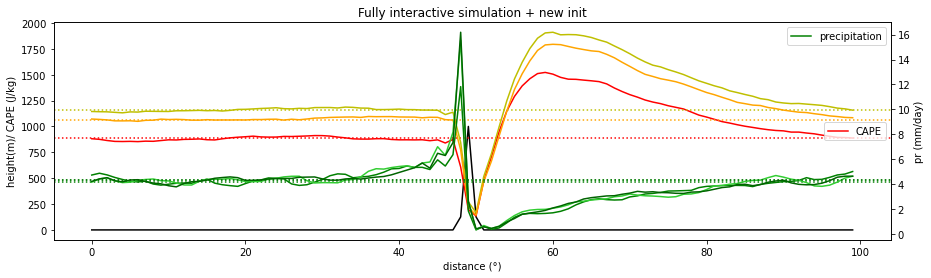

In [230]:
ax,ax2=plotsection(hgt)
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean.west_east,channelCAPEmean.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip.west_east,channelprecip.mean(['south_north','Time'])[::-1],color='green',label='precipitation')
ax2.axhline(channelprecip.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend(loc="center right")
ax2.legend()

ax.set_title("Fully interactive simulation + new init")

ax.plot(channelCAPEmean_newi .west_east,channelCAPEmean_newi .mean('south_north')[::-1],color='y',label='CAPE')
ax.axhline(channelCAPEmean_newi .isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='y',linestyle=':')

ax2.plot(channelprecip_newi .west_east,channelprecip_newi .mean(['south_north','Time'])[::-1],color='limegreen',label='precipitation')
ax2.axhline(channelprecip_newi .isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='limegreen',linestyle=':')

ax.plot(channelCAPEmean_youi .west_east,channelCAPEmean_youi .mean('south_north')[::-1],color='orange',label='CAPE')
ax.axhline(channelCAPEmean_youi .isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='orange',linestyle=':')

ax2.plot(channelprecip_youi .west_east,channelprecip_youi .mean(['south_north','Time'])[::-1],color='darkgreen',label='precipitation')
ax2.axhline(channelprecip_youi .isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='darkgreen',linestyle=':')

# Fixed evap & radiation

## Setting up radiation

### RTHRATEN

In [78]:
wrfou24 = xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/wrfout24_*")),combine='nested',concat_dim='Time',parallel=True)


In [98]:
# Mass-weighted mean radiative cooling (note this is not perfect, because just averaged over instantaneous values of radiative cooling, only output every 6 hours).
Cp=1004.
P_W = np.interp(channelwrf.ZNW.isel(Time=0)[::-1],channelwrf.ZNU.isel(Time=0)[::-1],channelwrf.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=channelwrf.PB[0,::-1,0,0].coords)
meanradcoolingc=(Cp*mass*wrfou24.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean(['Time','south_north','west_east'])).sum('bottom_top')/(Cp*mass.sum('bottom_top'))

print("Mass-weighted mean rad. cooling : %.4e K/s = %.4f K/day  "%(meanradcoolingc,86400*meanradcoolingc))

Mass-weighted mean rad. cooling : -1.5083e-05 K/s = -1.3032 K/day  


In [125]:
def f(sigma):
    return ((sigma > 0.9)*40*(sigma-1) + (sigma <= 0.9)*(sigma > 0.85)*(-4+2*26.5*(0.9-sigma)) + (sigma < 0.85)*(-1.35))*1e-5

In [126]:
float((mass*f(channelwrf.PB[-1,:,0,0]/1e5)).sum('bottom_top')/(mass.sum('bottom_top')))

-1.5093265005700858e-05

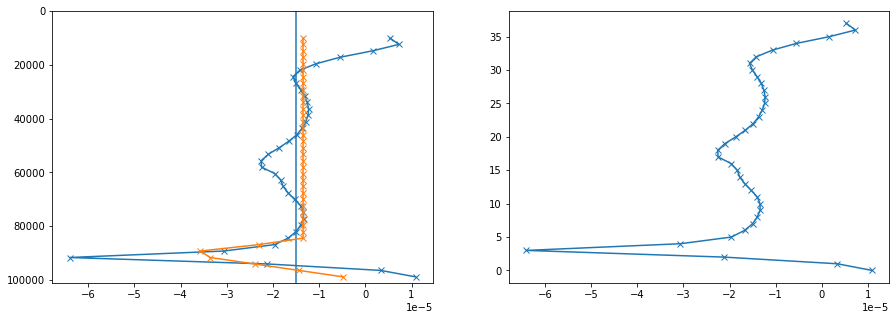

In [127]:
radcoolingc = wrfou24.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean(['Time','south_north','west_east'])

_,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].axvline(meanradcoolingc)
ax[0].plot(radcoolingc,channelwrf.PB[-1,:,0,0],'-x')
ax[0].plot(f(channelwrf.PB[-1,:,0,0]/1e5),channelwrf.PB[-1,:,0,0],'-x')
ax[0].set_ylim(101000,0)
ax[1].plot(radcoolingc,radcoolingc.bottom_top,'-x')

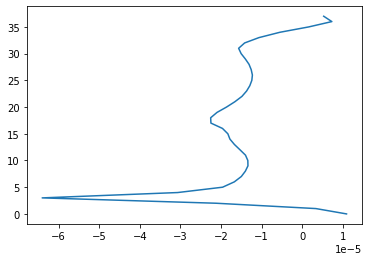

In [94]:
# Vertical structure
plt.plot(wrfou24.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean(['west_east','south_north','Time']).load(),wrfou24.bottom_top)

### T_eq

In [48]:
Tmean=channelwrf_p.T_p.isel(time=slice(800,1200)).mean(["time","south_north","west_east"]).load()
p = np.polyfit(np.array(Tmean.pressure/1000)[4:-1],np.array(Tmean)[4:-1],4)

parr=np.linspace(0,1010,1000)
fit = np.sum(p[::-1]*(np.ones(5)*parr[:,None]/1000)**range(5),axis=1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


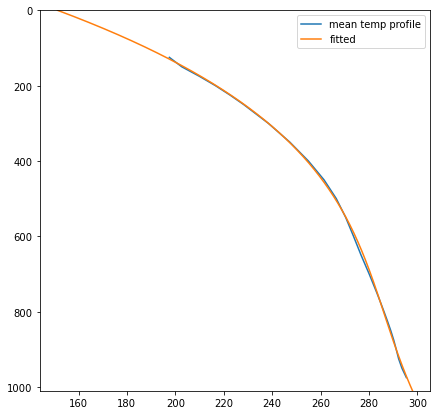

In [440]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(Tmean,Tmean.pressure,label="mean temp profile")
ax.plot(fit,parr,label='fitted')
ax.set_ylim(1010,0)
ax.legend()

## With radiative relaxation

In [50]:
%%time
channelwrf_fe = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_radrelax.wrf.100x10.mountain.100km.300d/",nfiles=30)
channelwrf_fe_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel_fe_radrelax.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 5.15 s, sys: 2.39 s, total: 7.54 s
Wall time: 10.2 s


In [51]:
channelprecip_fe = 4*(channelwrf_fe.RAINC+channelwrf_fe.RAINNC).isel(Time=slice(-800,-1)).diff('Time').persist()

In [52]:
%time channelcapecin_fe = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_radrelax.wrf.100x10.mountain.100km.300d/")
channelCAPEmean_fe = channelcapecin_fe.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,1200)).mean('Time')

CPU times: user 199 ms, sys: 535 ms, total: 734 ms
Wall time: 6.63 s


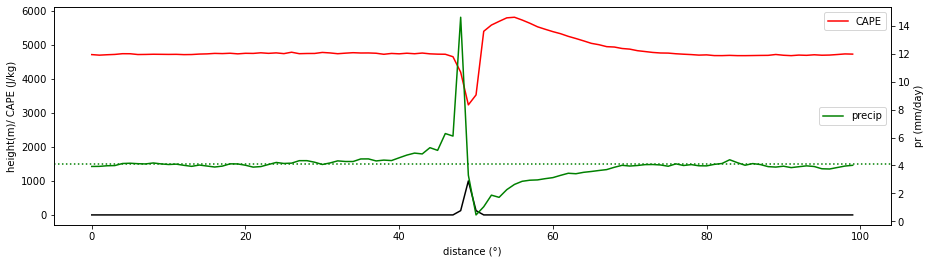

In [33]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean_fe.west_east,channelCAPEmean_fe.mean('south_north')[::-1],color='r',label='CAPE')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip_fe.west_east,channelprecip_fe.mean(['south_north','Time'])[::-1],color='green',label='precip')
ax2.axhline(channelprecip_fe.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend()
ax2.legend(loc="center right")


Text(0.5, 1.0, 'Evaporation')

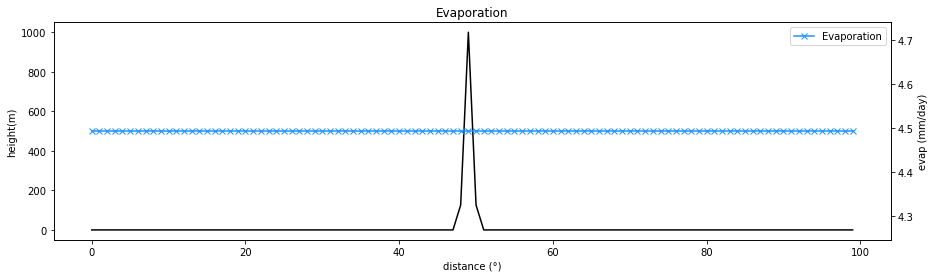

In [29]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("evap (mm/day)")
ax2.plot(channelwrf_fe.west_east,86400*channelwrf_fe.QFX.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='dodgerblue',label="Evaporation")
ax2.legend()
ax2.set_title("Evaporation")

In [28]:
Cp=1004.
P_W = np.interp(channelwrf_fe.ZNW.isel(Time=0)[::-1],channelwrf_fe.ZNU.isel(Time=0)[::-1],channelwrf_fe.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=channelwrf_fe.PB[0,::-1,0,0].coords)
radcooling=(Cp*mass*channelwrf_fe.RTHRATEN).sum('bottom_top')

Text(0.5, 1.0, 'Radiative cooling')

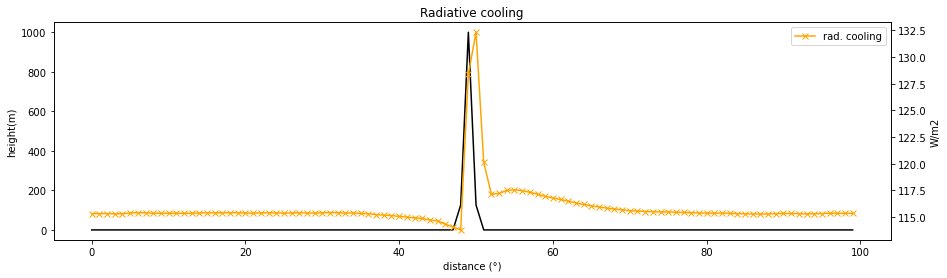

In [31]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("W/m2")
ax2.plot(channelwrf_fe.west_east,-radcooling.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='orange',label="rad. cooling")
ax2.legend()
ax2.set_title("Radiative cooling")

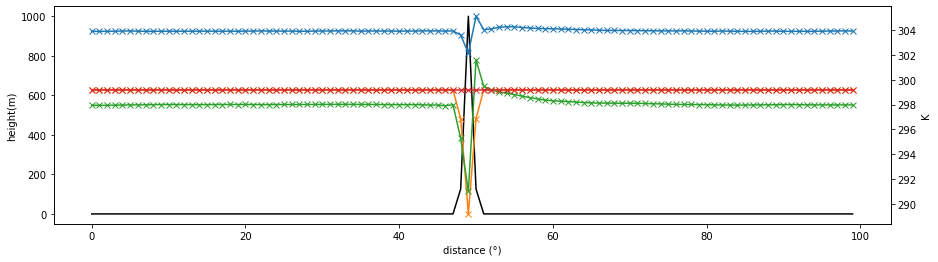

In [38]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("K")
ax2.plot(channelwrf_fe.west_east,channelwrf_fe.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fe.west_east,channelwrf_fe.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')

O° is upstream and 100° is downstream !!


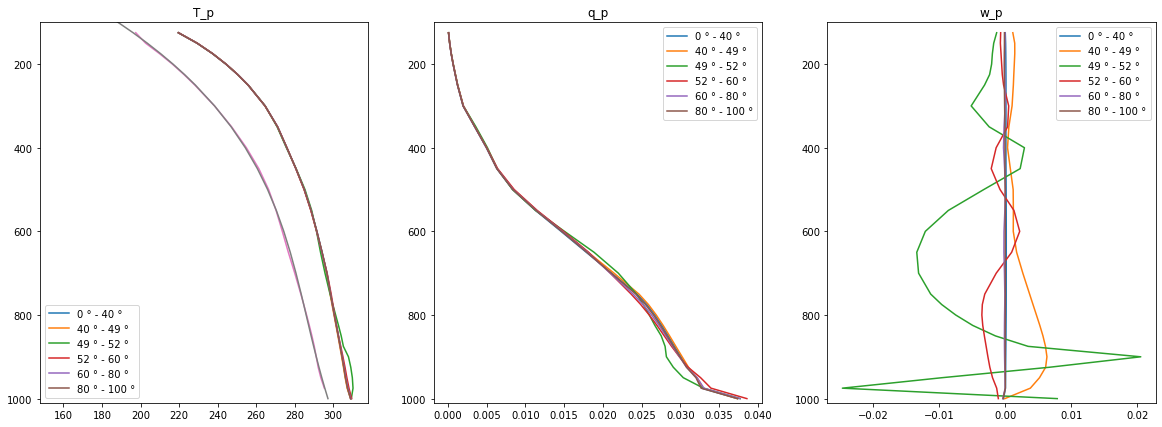

In [113]:
slices=[0,40,49,52,60,80,100]
print("O° is upstream and 100° is downstream !!")
fig, ax = plt.subplots(1,3,figsize=(20,7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    for j,var in enumerate(["T_p","q_p","w_p"]):
        for i in range(len(slices)-1):
            ax[j].plot(channelwrf_fe_p[var].isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"])[4:].load(),channelwrf_fe_p.pressure[4:],label="%i ° - %i °"%(slices[i],slices[i+1]))
        ax[j].set_title(var)
        ax[j].set_ylim(1010,100)
        ax[j].legend()
    ax[0].plot(Tmean,Tmean.pressure,label="ref profile")
    pnorm = Tmean.pressure/1000
    a0 = 151.3
    a1 = 416.7
    a2 = -494.3
    a3 = 254.9
    a4 = -31.3
    teq = a0 + a1*pnorm + a2*pnorm**2 + a3*pnorm**3 + a4*pnorm**4
    ax[0].plot(teq,Tmean.pressure,label="ref profile 2")


        

In [72]:
#evap
4.3/86400*2.26e6

112.47685185185185

In [73]:
9051*1004*1.5e-5

136.30806

## With fixed radiative cooling

In [19]:
%%time
channelwrf_fefr = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_frad.wrf.100x10.mountain.100km.300d/",nfiles=30)
channelwrf_fefr_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel_fe_frad.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 5.28 s, sys: 1.84 s, total: 7.11 s
Wall time: 11 s


In [20]:
channelprecip_fefr = 4*(channelwrf_fefr.RAINC+channelwrf_fefr.RAINNC).isel(Time=slice(-800,-1)).diff('Time').persist()

In [21]:
%time channelcapecin_fefr = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_frad.wrf.100x10.mountain.100km.300d/")
channelCAPEmean_fefr = channelcapecin_fefr.isel(mcape_mcin_lcl_lfc=0,Time=slice(-800,-1)).mean('Time')
channelCINmean_fefr = channelcapecin_fefr.isel(mcape_mcin_lcl_lfc=1,Time=slice(-800,-1)).mean('Time')

CPU times: user 153 ms, sys: 26.4 ms, total: 179 ms
Wall time: 5.01 s


Text(0.5, 1.0, 'Fixed evap & rad. cooling')

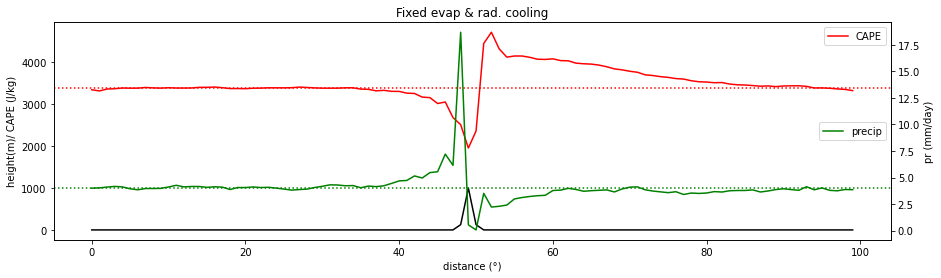

In [56]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean_fefr.west_east,channelCAPEmean_fefr.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean_fefr.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip_fefr.west_east,channelprecip_fefr.mean(['south_north','Time'])[::-1],color='green',label='precip')
ax2.axhline(channelprecip_fefr.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend()
ax2.legend(loc="center right")
ax.set_title("Fixed evap & rad. cooling")

Text(0.5, 1.0, 'Evaporation')

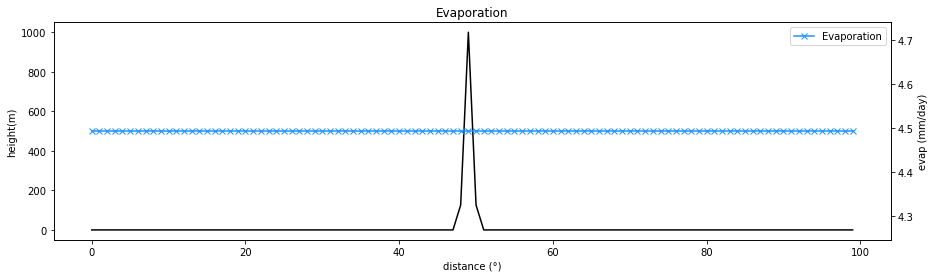

In [29]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("evap (mm/day)")
ax2.plot(channelwrf_fefr.west_east,86400*channelwrf_fefr.QFX.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='dodgerblue',label="Evaporation")
ax2.legend()
ax2.set_title("Evaporation")

In [87]:
Cp=1004.
P_W = np.interp(channelwrf_fefr.ZNW.isel(Time=0)[::-1],channelwrf_fefr.ZNU.isel(Time=0)[::-1],channelwrf_fefr.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=channelwrf_fefr.PB[0,::-1,0,0].coords)
radcooling=(Cp*mass*channelwrf_fefr.RTHRATEN).sum('bottom_top')

(130.0, 140.0)

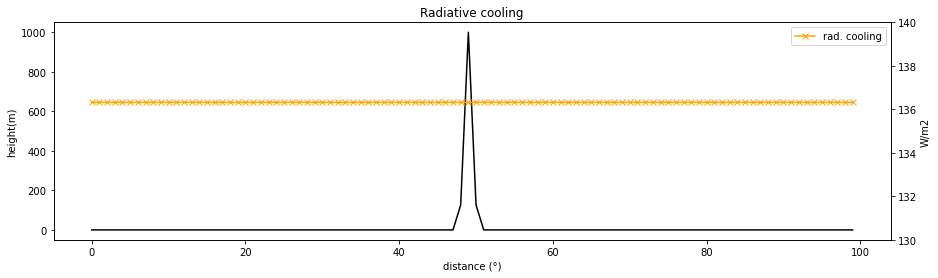

In [89]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("W/m2")
ax2.plot(channelwrf_fefr.west_east,-radcooling.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='orange',label="rad. cooling")
ax2.legend()
ax2.set_title("Radiative cooling")
ax2.set_ylim(130,140)

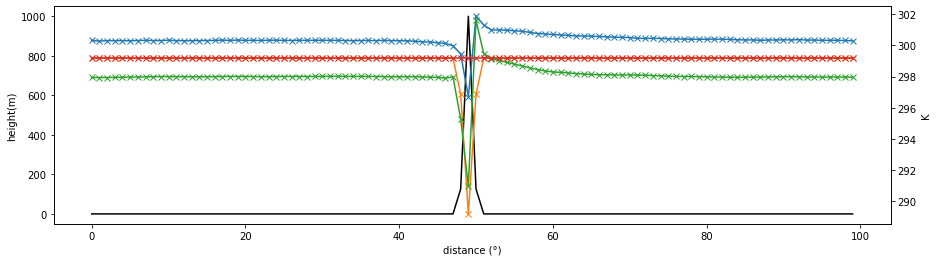

In [90]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("K")
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefr.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefr.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')

O° is upstream and 100° is downstream !!


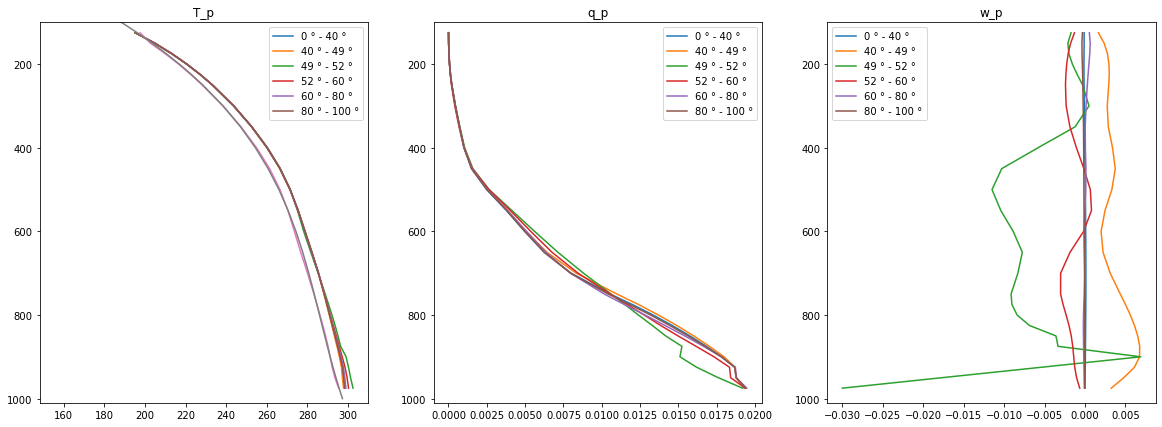

In [114]:
slices=[0,40,49,52,60,80,100]
print("O° is upstream and 100° is downstream !!")
fig, ax = plt.subplots(1,3,figsize=(20,7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    for j,var in enumerate(["T_p","q_p","w_p"]):
        for i in range(len(slices)-1):
            ax[j].plot(channelwrf_fefr_p[var].isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"])[4:].load(),channelwrf_fefr_p.pressure[4:],label="%i ° - %i °"%(slices[i],slices[i+1]))
        ax[j].set_title(var)
        ax[j].set_ylim(1010,100)
        ax[j].legend()
    ax[0].plot(Tmean,Tmean.pressure,label="ref profile")
    pnorm = Tmean.pressure/1000
    a0 = 151.3
    a1 = 416.7
    a2 = -494.3
    a3 = 254.9
    a4 = -31.3
    teq = a0 + a1*pnorm + a2*pnorm**2 + a3*pnorm**3 + a4*pnorm**4
    ax[0].plot(teq,Tmean.pressure,label="ref profile 2")

        

Text(0.5, 1.0, 'Fixed evap & rad. cooling - W (nonlinear scale)')

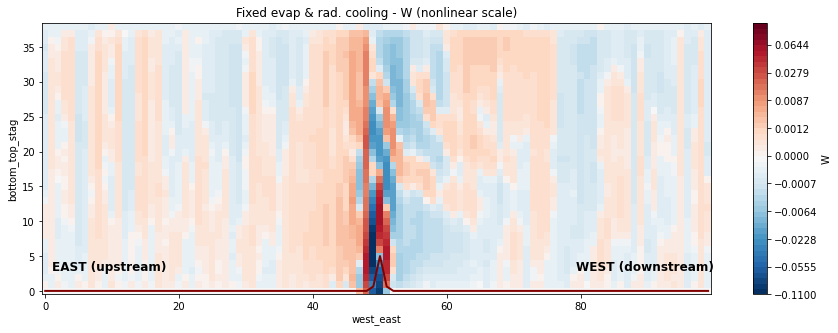

In [45]:
_,ax=plt.subplots(1,1,figsize=(15,5))
w=channelwrf_fefr.W.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1]
w.plot(ax=ax, x='west_east', levels=np.linspace(-(0.11)**(1/3),0.11**(1/3),50)**3)
ax.plot(channelwrf_fefr.west_east, channelwrf_fefr.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
add_text(ax)
ax.set_title("Fixed evap & rad. cooling - W (nonlinear scale)")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/plots/skewt.py:131: MatplotlibDeprecationWarning: 
The 'label' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any par

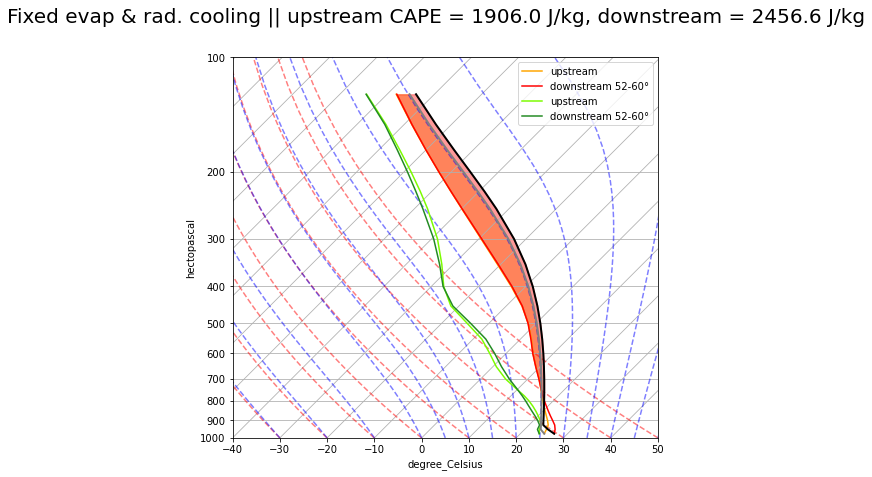

In [39]:
fig=plot_skewt(channelwrf_fefr_p, "Fixed evap & rad. cooling")

In [64]:
channelwrf_fefr.LH.mean().load()

<xarray.DataArray 'LH' ()>
array(129.8723, dtype=float32)

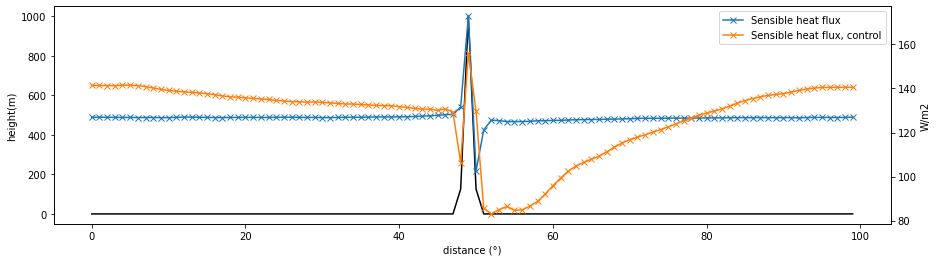

In [70]:
hfx=channelwrf_fefr.HFX.isel(Time=slice(400,1000)).mean('Time')
lhf= channelwrf_fefr.LH.isel(Time=slice(400,1000)).mean('Time')
hfxc=channelwrf.HFX.isel(Time=slice(400,2400)).mean('Time')
lhfc= channelwrf.LH.isel(Time=slice(400,2400)).mean('Time')


_,ax2 = plotsection(hgt)
ax2.set_ylabel("W/m2")
ax2.plot(channelwrf_fefr.west_east,(hfx+lhf).mean('south_north')[::-1],'-x',label="Sensible heat flux")
ax2.plot(channelwrf_fefr.west_east,(hfxc+lhfc).mean('south_north')[::-1],'-x',label="Sensible heat flux, control")

#ax2.plot(channelwrf_fefr.west_east,lhf.mean('south_north')[::-1],'-x',label="Latent heat flux")
ax2.legend()

## With fixed radiative cooling, specified vertical structure

In [22]:
%%time
channelwrf_fefrv1 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_fradv1.wrf.100x10.mountain.100km.300d/",nfiles=30)
channelwrf_fefrv2 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_fradv2.wrf.100x10.mountain.100km.300d/",nfiles=30)

channelwrf_fefrv1_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel_fe_fradv1.wrf.100x10.mountain.100km.300d/",nfiles=30)
channelwrf_fefrv2_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel_fe_fradv2.wrf.100x10.mountain.100km.300d/",nfiles=30)

CPU times: user 11.3 s, sys: 4.81 s, total: 16.1 s
Wall time: 23.5 s


In [25]:
channelprecip_fefrv1 = 4*(channelwrf_fefrv1.RAINC+channelwrf_fefrv1.RAINNC).isel(Time=slice(-800,-1)).diff('Time').persist()
channelprecip_fefrv2 = 4*(channelwrf_fefrv2.RAINC+channelwrf_fefrv2.RAINNC).isel(Time=slice(-800,-1)).diff('Time').persist()

In [23]:
%time channelcapecin_fefrv1 = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_fradv1.wrf.100x10.mountain.100km.300d/")
channelCAPEmean_fefrv1 = channelcapecin_fefrv1.isel(mcape_mcin_lcl_lfc=0,Time=slice(-800,-1)).mean('Time')
channelCINmean_fefrv1 = channelcapecin_fefrv1.isel(mcape_mcin_lcl_lfc=1,Time=slice(-800,-1)).mean('Time')
channelLFCmean_fefrv1 = channelcapecin_fefrv1.isel(mcape_mcin_lcl_lfc=3,Time=slice(-800,-1)).mean('Time')


%time channelcapecin_fefrv2 = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_fradv2.wrf.100x10.mountain.100km.300d/")
channelCAPEmean_fefrv2 = channelcapecin_fefrv2.isel(mcape_mcin_lcl_lfc=0,Time=slice(-800,-1)).mean('Time')
channelCINmean_fefrv2 = channelcapecin_fefrv2.isel(mcape_mcin_lcl_lfc=1,Time=slice(-800,-1)).mean('Time')
channelLFCmean_fefrv2 = channelcapecin_fefrv2.isel(mcape_mcin_lcl_lfc=3,Time=slice(-800,-1)).mean('Time')


CPU times: user 175 ms, sys: 18.3 ms, total: 193 ms
Wall time: 5.89 s
CPU times: user 165 ms, sys: 21 ms, total: 186 ms
Wall time: 5.81 s


Text(0.5, 1.0, 'Fixed evap & rad. cooling')

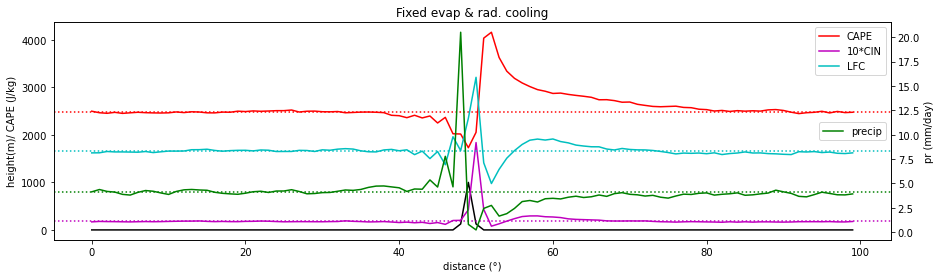

In [46]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean_fefrv1.west_east,channelCAPEmean_fefrv1.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean_fefrv1.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax.plot(channelCINmean_fefrv1.west_east,10*channelCINmean_fefrv1.mean('south_north')[::-1],color='m',label='10*CIN')
ax.axhline(10*channelCINmean_fefrv1.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='m',linestyle=':')

ax.plot(channelLFCmean_fefrv1.west_east,channelLFCmean_fefrv1.mean('south_north')[::-1],color='c',label='LFC')
ax.axhline(channelLFCmean_fefrv1.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='c',linestyle=':')


ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip_fefrv1.west_east,channelprecip_fefrv1.mean(['south_north','Time'])[::-1],color='green',label='precip')
ax2.axhline(channelprecip_fefrv1.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend()
ax2.legend(loc="center right")
ax.set_title("Fixed evap & rad. cooling")

Text(0.5, 1.0, 'Fixed evap & rad. cooling')

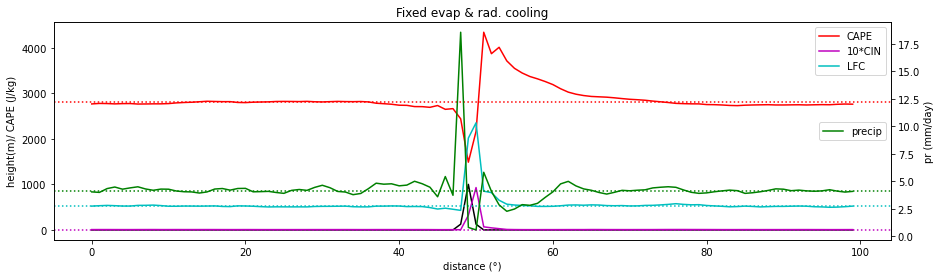

In [47]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean_fefrv2.west_east,channelCAPEmean_fefrv2.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean_fefrv2.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax.plot(channelCINmean_fefrv2.west_east,10*channelCINmean_fefrv2.mean('south_north')[::-1],color='m',label='10*CIN')
ax.axhline(channelCINmean_fefrv2.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='m',linestyle=':')

ax.plot(channelLFCmean_fefrv2.west_east,channelLFCmean_fefrv2.mean('south_north')[::-1],color='c',label='LFC')
ax.axhline(channelLFCmean_fefrv2.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='c',linestyle=':')


ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip_fefrv2.west_east,channelprecip_fefrv2.mean(['south_north','Time'])[::-1],color='green',label='precip')
ax2.axhline(channelprecip_fefrv2.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend()
ax2.legend(loc="center right")
ax.set_title("Fixed evap & rad. cooling")

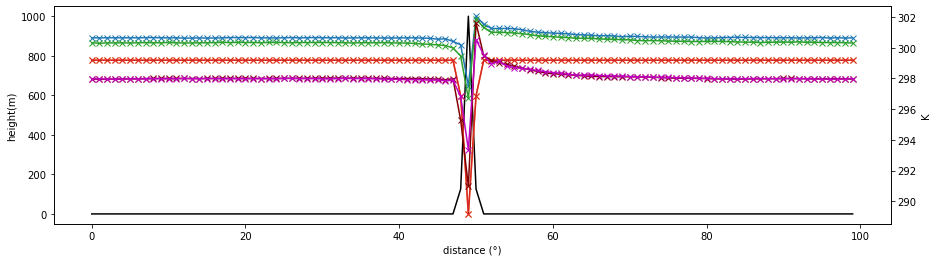

In [23]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("K")
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefrv1.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefrv1.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefr.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefr.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')

ax2.plot(channelwrf_fefr.west_east,channelwrf.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color="maroon")
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefrv2.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color="m")

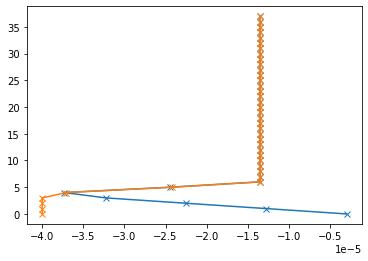

In [24]:
radcoolingfrv1 = channelwrf_fefrv1.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean(['Time','south_north','west_east'])
radcoolingfrv2 = channelwrf_fefrv2.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean(['Time','south_north','west_east'])
plt.plot(radcoolingfrv1,radcoolingfrv1.bottom_top,'-x')
plt.plot(radcoolingfrv2,radcoolingfrv2.bottom_top,'-x')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-pack

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/plots/skewt.py:131: MatplotlibDeprecationWarning: 
The 'label' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'label', they should be passed as keyword, not positionally.
  return SkewXTick(self.axes, None, '', major=major)


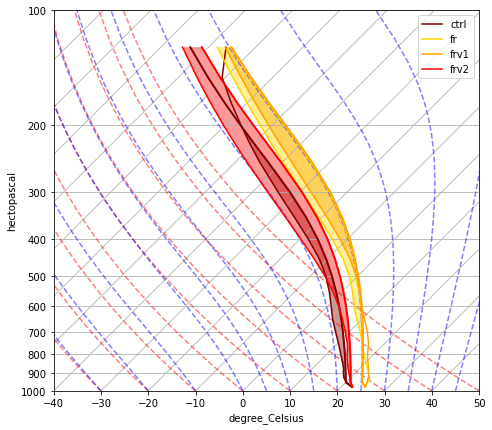

In [37]:
def plot_skewt_ups(sim,skew,color,lbl):
    slices=[0,40,49,52,60,80,100]
    P = np.array(sim.pressure)[4:-1]* units.hPa
    i=0
    Tups = units.degK*np.array(sim.T_p.isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load())[4:-1]
    qups = np.array(sim.q_p.isel(west_east=slice(100-slices[i+1],100-slices[i]),time=slice(400,1200)).mean(["time","south_north","west_east"]).load())[4:-1]

    P=P[::-1]
    Tups=Tups[::-1]
    qups=qups[::-1]

    skew.plot(P, Tups,color=color ,label=lbl)
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    # Calculate full parcel profile and add to plot as black line
    profups = mpcalc.parcel_profile(P, Tups[0], Tdups[0]).to('degC')
    skew.plot(P, profups, color=color, linewidth=2)
    skew.shade_cape(P, Tups, profups,color=color)
    
fig = plt.figure(figsize=(10,7))
skew = SkewT(fig, rotation=45)

plot_skewt_ups(channelwrf_p       ,skew,"maroon","ctrl")
plot_skewt_ups(channelwrf_fefr_p  ,skew,"gold","fr")
plot_skewt_ups(channelwrf_fefrv1_p,skew,"orange","frv1")
plot_skewt_ups(channelwrf_fefrv2_p,skew,"red","frv2")

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 50)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
plt.legend()
#fig.suptitle(title + " || upstream CAPE = %.1f J/kg, downstream = %.1f J/kg"%(mpcalc.cape_cin(P, Tups, Tdups,profups)[0]/units("J/kg"),mpcalc.cape_cin(P, Tdws, Tddws,profdws)[0]/units("J/kg")),fontsize=20)


# What sets the convective time scale

Text(0.5, 1.0, 'tau & CIN')

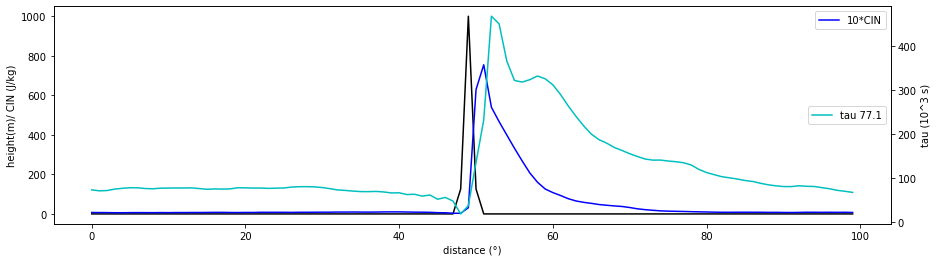

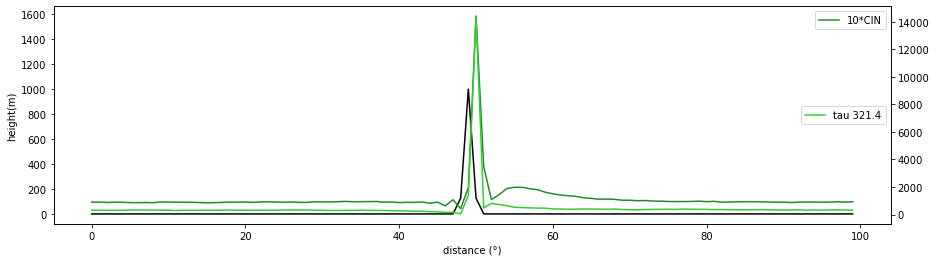

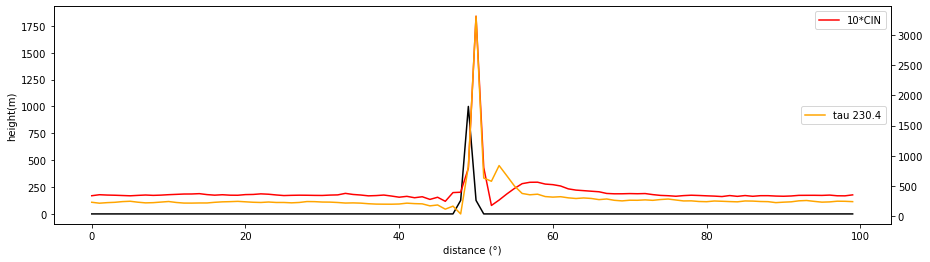

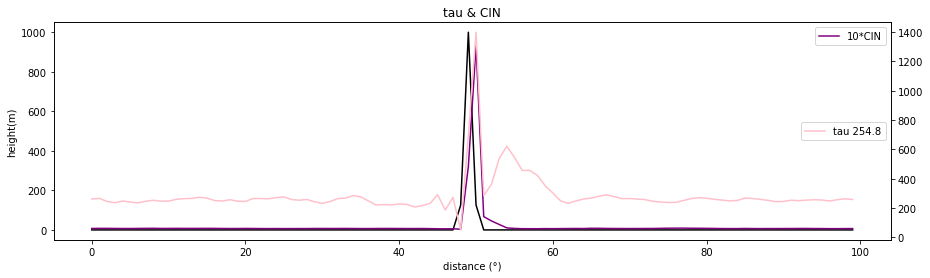

In [34]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CIN (J/kg)")
ax2.set_ylabel("tau (10^3 s)")
conversion_factor = 1/(2.26e6/86400/10000)/1000

tau=conversion_factor*channelCAPEmean.mean('south_north')[::-1]/channelprecip.mean(['Time','south_north'])[::-1]
ax2.plot(channelCAPEmean.west_east,tau,color='c',label='tau %.1f'%(tau[:30].mean()))
ax.plot(channelCINmean.west_east,10*channelCINmean.mean('south_north')[::-1],color='blue',label='10*CIN')
ax.legend();ax2.legend(loc="center right")
ax,ax2=plotsection(hgt)
tau = conversion_factor*channelCAPEmean_fefr.mean('south_north')[::-1]/channelprecip_fefr.mean(['Time','south_north'])[::-1]
ax2.plot(channelCAPEmean_fefr.west_east,tau,color='limegreen',label='tau %.1f'%(tau[:30].mean()))
ax.plot(channelCINmean_fefr.west_east,10*channelCINmean_fefr.mean('south_north')[::-1],color='forestgreen',label='10*CIN')
ax.legend();ax2.legend(loc="center right")
ax,ax2=plotsection(hgt)
tau=conversion_factor*channelCAPEmean_fefrv1.mean('south_north')[::-1]/channelprecip_fefrv1.mean(['Time','south_north'])[::-1]
ax2.plot(channelCAPEmean_fefrv1.west_east,tau,color='orange',label='tau %.1f'%(tau[:30].mean()))
ax.plot(channelCINmean_fefrv1.west_east,10*channelCINmean_fefrv1.mean('south_north')[::-1],color='red',label='10*CIN')
ax.legend();ax2.legend(loc="center right")
ax,ax2=plotsection(hgt)
tau=conversion_factor*channelCAPEmean_fefrv2.mean('south_north')[::-1]/channelprecip_fefrv2.mean(['Time','south_north'])[::-1]
ax2.plot(channelCAPEmean_fefrv2.west_east,tau,color='pink',label='tau %.1f'%(tau[:30].mean()))
ax.plot(channelCINmean_fefrv2.west_east,10*channelCINmean_fefrv2.mean('south_north')[::-1],color='purple',label='10*CIN')

ax.legend();ax2.legend(loc="center right")

ax.set_title("tau & CIN")

# M_h tests on reference sounding

In [3]:
# Jordan Sounding
pjordan = 100*np.array([100.,125.,150.,175.,200., 250., 300., 350., 400., 450., 500., 550., 600.,650., 700., 750., 800., 850., 900., 950.,1000.,1016.3])
Tjordan = 273.15+np.array([-74.6,-71.5,-66.7,-61.,-55.3,-44.2,-34.5,-26.1,-18.9,-12.8,-7.6,-3.,1.,4.6,7.9,10.7,13.1,15.6,18.3,21.2,24.3,24.7])
pjordan=pjordan[4:]
Tjordan=Tjordan[4:]

In [5]:
qj = qsat(Tjordan,pjordan/100)
print(2.26e6*qj)

[  141.55552784   445.4793805   1106.83750869  2279.85687376
  4065.30491434  6498.4994192   9372.44313986 12504.14772167
 15489.15899047 18478.47146051 21568.71876833 24330.17409096
 26743.91667876 29617.92566774 33233.30132639 37743.25611225
 43344.6390634  43689.22832636]


In [6]:
print(1004.*Tjordan)

[218721.4 229865.8 239604.6 248038.2 255267.  261391.4 266612.2 271230.6
 275246.6 278861.  282174.2 284985.4 287395.  289905.  292615.8 295527.4
 298639.8 299041.4]


(101700.0, 0.0)

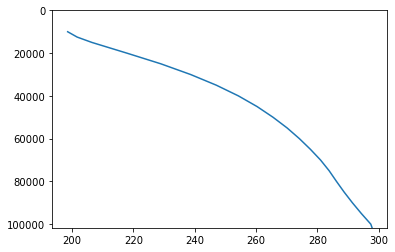

In [123]:
plt.plot(Tjordan,pjordan)
plt.ylim(100*1017,0)

(101700.0, 0.0)

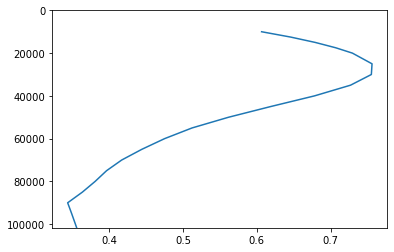

In [124]:
plt.plot(A_npy(Tjordan,pjordan),pjordan)
plt.ylim(100*1017,0)

(101700.0, 0.0)

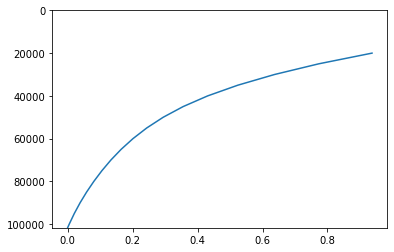

In [178]:
plt.plot(Aplus_npy(Tjordan,pjordan),pjordan)
plt.ylim(100*1017,0)

(101700.0, 0.0)

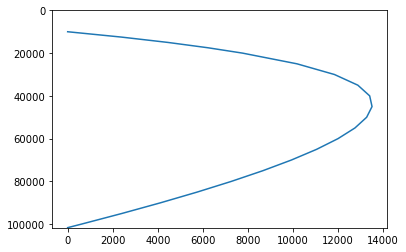

In [169]:
plt.plot(Omega_npy(Tjordan,pjordan),pjordan)
plt.ylim(100*1017,0)

# QTCM Diagnostics

In [370]:
Aref = A(channelwrf_p.T_p.isel(time=slice(400,1200)).mean(["time","south_north","west_east"]).load(),
         100*channelwrf_p.isel(time=slice(400,1200)).pressure.load()
        )
#Bref = 

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [377]:
Tref = channelwrf_p.T_p.isel(time=slice(400,1200)).mean(["time","south_north","west_east"])
qref = channelwrf_p.q_p.isel(time=slice(400,1200)).mean(["time","south_north","west_east"])
qsatref = qsat(Tref,channelwrf_p.isel(time=slice(400,1200)).pressure.load())                                     

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(1000.0, 100.0)

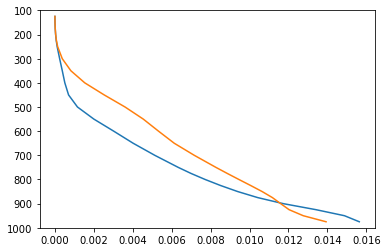

In [380]:
plt.plot(qref,Tref.pressure)
plt.plot(0.8*qsatref,Tref.pressure)
plt.ylim(1000,100)